# <div align="center"><span style="font-family: Georgia; color:#01386a">Imports</div>

In [47]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Latex, Markdown, display
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

import string
from string import punctuation

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

stop_words = set(stopwords.words("english"))

import re
from string import punctuation

import numpy as np
import pandas as pd
import shap
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from nltk.corpus import stopwords

# !pip install TextBlob
from textblob import TextBlob

shap.initjs()

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from transformers_interpret import SequenceClassificationExplainer

<div align="left"><span style="font-family: Georgia; color:#3b638c"><h2>Import Data</div>

In [2]:
df = pd.read_csv("askscience_data.csv")
print(len(df))

4205


# <div align="center"><span style="font-family: Georgia; color:#01386a">Overall Summary</div>
* Did some feature engineering and looked at some base models for tabular (catboost, RF etc...)
* did a very basic BERT training with the text data
* There is some promise with somme high level text features, time of day/week, but I didn't get too deep into the sentiment and user behaviour/sub-subreddit behaviour that I think would be pretty interesting (especially with richer historic data and features) 
* If I had more time I would look at embedding some additional categorical data (e.g., with catboost) and stacking it on to BERT, or acquiring more user data to extend the analysis
* Part of this notebook was copied and pasted from google collab (which I jumped on for the GPU).  I can share that notebook as well. 

# <div align="center"><span style="font-family: Georgia; color:#01386a"> Problem Statement</div>

<font size = "3"> <p style="font-family:verdana"> The description of the data challenge is as follows:</p></font>

> The file `askscience_data.csv` is a collection of posts from the subreddit r/askscience. The task comes with two parts:

>1. **Determine the attributes of a successful post on r/askscience**
>2. **Build a model that can predict the score of a post on r/askscience given at least the title and body of the post**
(There is no need to limit it to just the title and body, but you must explain why you chose the features you did).

# <div align="center"><span style="font-family: Georgia; color:#01386a">Frame the Problem</div>

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Define Success Criteria</div>

<font size = "3"> <p style="font-family:verdana"> We have two primary metrics that **could** be targets: `score` and `upvote percentage`. In real life, I would explore a composite metric that more accurately reflects both the activity of the post and overall sentiment. I would also pursue a better understanding of the business objectives at stake and the success criteria. After looking at some diverging score/upvote cases, and thinking about the behavioural complexcities here, I went with `score` (my more detailed personal notes and explanations are below).  To more explicitly define my interpretations and assumptions:
- I assume this question is interested in how the avaiable text, date and minor demographic features relate to the likelihood that a post will recieve a high score.
- as already intimated, the definition of `success` will be simplified to represent the score. </p></font> 

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Notes on Metrics</div>

<font size = "3"> <p style="font-family:verdana"> **Score** </p></font> 

&#10148;<font size = "3"> <span style="font-family:verdana"> Represents the net number of upvotes minus the net number of downvotes, and is the most visible metric you can see right next to snoo </span></font>
</br>
&#10148;<font size = "3"> <span style="font-family:verdana">  indicator of the post's relative popularity within the subreddit, but it doesn't directly indicate the total number of votes or overal engagement </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana">  We should also keep in mind: Votes are quite different from the passive behaviours that in many ways reflect an equal and more thoughtful engagement than more vocal participation. A quiet group of devout followers can be just as impactful (depending on the particular use-case we are considering). 
 </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> Scores and upvote percentage can disagree as with controversial posts, vote manipulation, subreddit size and community engagement where <span style='background :#d0fefe; color: black; font-size:18px;' > smaller subreddits with few but dedicated active users may see posts with high score with a relatively lower upvote percentage, while larger subreddits with more diverse opinions may see a closer alignment between the score and upvote percentage. </span>
    </span></font> </br>

<font size = "3"> <p style="font-family:verdana"> **Upvote Percentage** </p></font> 

&#10148;<font size = "3"> <span style="font-family:verdana"> Ratio of upvotes to the total number of votes received by a post; more inconspicuous than score: you need to hover over it. </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> provides insight into the overall sentiment of the community towards the post </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> A higher upvote percentage suggests that a larger proportion of users who voted on the post have expressed positive sentiment through upvotes </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> useful when the goal is to gauge the sentiment or approval level of the community towards the post </span></font> </br>


# <div align="center"><span style="font-family: Georgia; color:#01386a">EDA </div>

In [3]:
df.nunique()

Unnamed: 0      2732
title           3705
body            2488
tag               32
datetime        3707
author          3314
score           1799
upvote_ratio      72
url             3707
dtype: int64

<font size = "3"> <p style="font-family:verdana"> Some initial comments:</p></font>

&#10148;<font size = "3"> <span style="font-family:verdana"> There are non-unique values for the `Unnamed: 0` column. Looks like it is possibly related to blocks from scraping--Regardless, I did not see any systmetic differences between the three "groups" that reset themselves like Benjamin Button </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> Title and urls have almost the same unique counts, which makes sense </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> The unique values of the body are lower than the unique values of the title.  I assume this is because the body is often left empty (i.e., when the title speaks for iteself), <s> but I will double check this. </s> , which checks out. </span></font> </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> We can tell right from the unique urls vs unique authors that some authors created multiple posts--Their popularity could have predictive signal, so <s> we should investigate more about this </s> I investigated this a bit--but ultimately since decided on the above terms (i.e., sticking to more objective, derscriptive features rather than making this a fascinating psychological thriller. </span></font> 

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Create analysis dataframe </div>

&#10148;<font size = "3"> <span style="font-family:verdana"> Feature engineering/cleaning </span></font> </br>

Added in some keywords I thought might be useful. Turns out they didn't do much.  It goes without saying that there is rooom to do a lot more on the data exploration/engineering front. I believe that is where a project like this can benefit the most.  

In [24]:
class TextFeatureExtractor:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))

    def count_chars(self, text):
        return len(text)

    def count_words(self, text):
        return len(text.split())

    def count_capitals(self, text):
        return sum(1 for c in text if c.isupper())

    def compute_caps_vs_length(self, text, char_count):
        return float(self.count_capitals(text)) / float(char_count + 0.0000001)

    def count_exclamation_marks(self, text):
        return text.count("!")

    def count_question_marks(self, text):
        return text.count("?")

    def count_punctuation(self, text):
        return sum(text.count(w) for w in ".,;:")

    def count_symbols(self, text):
        return sum(text.count(w) for w in r"*&$%/:;")

    def count_unique_words(self, text):
        return len(set(w for w in text.split()))

    def compute_words_vs_unique(self, num_unique_words, num_words):
        return num_unique_words / num_words

    def count_sad_emoticons(self, text):
        return sum(text.count(w) for w in (":-<", ":()", ";-()", ";("))

    def compute_word_density(self, char_count, num_words):
        return char_count / (num_words + 1)

    def count_punctuation_chars(self, text):
        return len("".join(_ for _ in text if _ in punctuation))

    def count_uppercase_words(self, text):
        return len([word for word in text.split() if word.isupper()])

    def count_stopwords(self, text):
        return len([word for word in text.split() if word.lower() in self.stop_words])

    def count_title_words(self, text):
        return len([word for word in text.split() if word.istitle()])

    def compute_mean_word_length(self, text):
        return np.mean([len(word) for word in text.split()])

    def compute_punctuation_percent(self, num_punctuation, num_words):
        return num_punctuation * 100 / num_words

    def compute_polarity(self, text):
        return TextBlob(text).sentiment.polarity

    def compute_subjectivity(self, text):
        return TextBlob(text).sentiment.subjectivity

    def tag_part_of_speech(self, text):
        # Implement your refined part-of-speech tagging function here
        pass

    def extract_text_features(
        self, df, text_column, get_pos_feats=False, get_textblob_sentiment=True
    ):
        df[f"{text_column}_char_count"] = df[text_column].apply(self.count_chars)
        df[f"{text_column}_num_words"] = df[text_column].apply(self.count_words)

        df["capitals"] = df[text_column].apply(self.count_capitals)
        df["caps_vs_length"] = df.apply(
            lambda row: self.compute_caps_vs_length(
                row[text_column], row[f"{text_column}_char_count"]
            ),
            axis=1,
        )

        df["num_exclamation_marks"] = df[text_column].apply(
            self.count_exclamation_marks
        )
        df["num_question_marks"] = df[text_column].apply(self.count_question_marks)
        df["num_punctuation"] = df[text_column].apply(self.count_punctuation)
        df["num_symbols"] = df[text_column].apply(self.count_symbols)

        return df

In [25]:
# Data cleaning and target variable functions
dfa = df.copy()
dfa["datetime"] = pd.to_datetime(dfa["datetime"])

dfa["year"] = dfa["datetime"].dt.year
dfa["month"] = dfa["datetime"].dt.month
dfa["day_of_week"] = dfa["datetime"].dt.day_name()
dfa["hour_of_day"] = dfa["datetime"].dt.hour

# Create and order the list of 12-hour time periods
dfa["12_hour"] = dfa["datetime"].apply(lambda x: x.strftime("%I %p"))
hours = list(dfa["12_hour"].unique())
hours.sort()
twelve_hour_index = [x for x in hours if "AM" in x] + [x for x in hours if "PM" in x]

# Keyword score calculation
keywords = [
    "AMA",  # AMA - Ask Me Anything
    "ELI5",  # ELI5 - Explain Like I'm 5
    "TIL",  # TIL - Today I Learned
    "PSA",  # PSA - Public Service Announcement
    "OC",  # OC - Original Content
    "TL;DR",  # TL;DR - Too Long; Didn't Read
    "MRW",  # MRW - My Reaction When
    "MFW",  # MFW - My Face When
    "IAMA",  # IAMA - I Am A
    "AMAA",  # AMAA - Ask Me Almost Anything
    "TIFU",  # TIFU - Today I F**ked Up
    "FTFY",  # FTFY - Fixed That For You
    "IMO",  # IMO - In My Opinion
    "CMV",  # CMV - Change My View
]

dfa["keyword_score"] = np.nan

for i, row in dfa.iterrows():
    title = row["title"]
    body = row["body"]
    score = 0

    if isinstance(title, str) and isinstance(body, str):
        # Count the keyword hits in the title
        for keyword in keywords:
            if re.search(r"\b{}\b".format(keyword), title, flags=re.IGNORECASE):
                score += 1

        # Count the keyword hits in the body
        for keyword in keywords:
            if re.search(r"\b{}\b".format(keyword), body, flags=re.IGNORECASE):
                score += 1

    # Assign the keyword score to the corresponding row
    dfa.at[i, "keyword_score"] = score

# Target variable creation
dfa["binary_target"] = pd.qcut(dfa["score"], q=3, labels=False)
dfa["upvote_target_ratio"] = pd.qcut(dfa["upvote_ratio"], q=3, labels=False)

# Text preprocessing
dfa["body"] = dfa["body"].fillna("")
dfa["text"] = dfa["title"] + " " + dfa["body"]

# Perform feature extraction
extractor = TextFeatureExtractor()
dfa = extractor.extract_text_features(dfa, "text")

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Visualize Variables</div>
- these are pretty ugly but it's a first scan for patterns [If you have the collapsing extension enabled you can bypass some clutter]
- from here we can see an obvious impact of `tag`, looks like `day of week` and `time of day` might be preditive--although we have to be a bit careful here. I didn't have time to run stats, but the latest group (from January - February) have a lot of variation and are small but mighty.  I would go back and embed datetime if I had time and stack that with bert etc.. to see if we can pull out some interesting relationships that aren't obvious at first blush.

In [28]:
## these are from Saturday and everything crashed so they won/t be run-able
def return_grouped_plot(
    x, y, order=None, title=None, x_label=None, y_label=None, save_path=None
):
    try:
        grouped_df = dfa.groupby([x, y]).size().reset_index(name="count")
        group_totals = grouped_df.groupby(y)["count"].transform("sum")
        grouped_df["percentage"] = grouped_df["count"] / group_totals * 100

        # Create a countplot with hue based on 'target' and normalize using 'percentage'
        if order:
            sns.barplot(data=grouped_df, x=x, y="percentage", hue=y, order=order)
        else:
            sns.barplot(data=grouped_df, x=x, y="percentage", hue=y)

        # Set labels and title
        plt.xticks(rotation=85)
        plt.xlabel(x_label if x_label else "Group Variable")
        plt.ylabel(y_label if y_label else "Percentage")
        plt.title(
            title if title else "Normalized Countplot by Group Variable and Target"
        )

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path)

        # Show the plot
        plt.show()

    except (KeyError, ValueError) as e:
        print(f"Error occurred: {str(e)}")

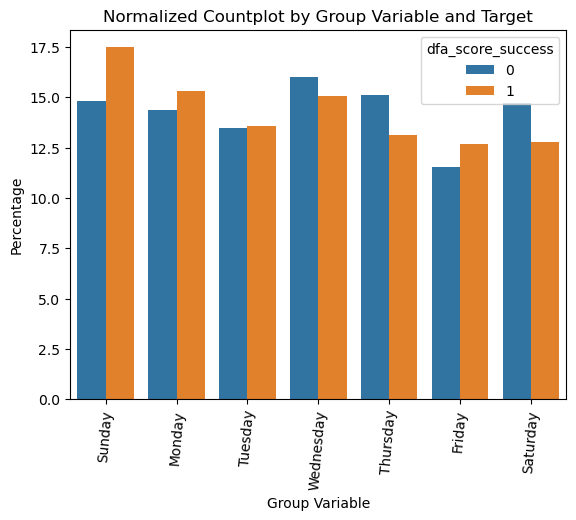

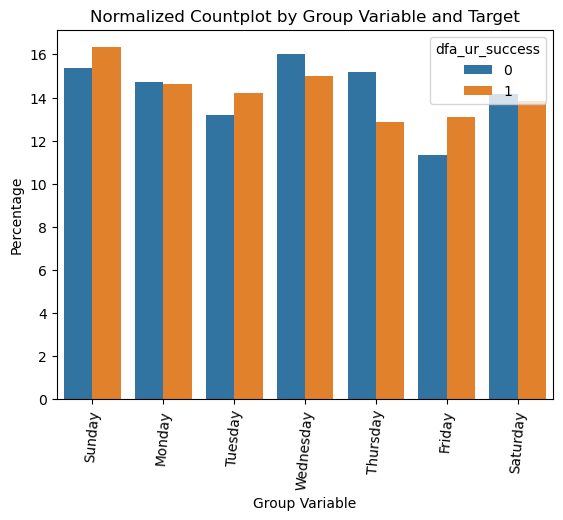

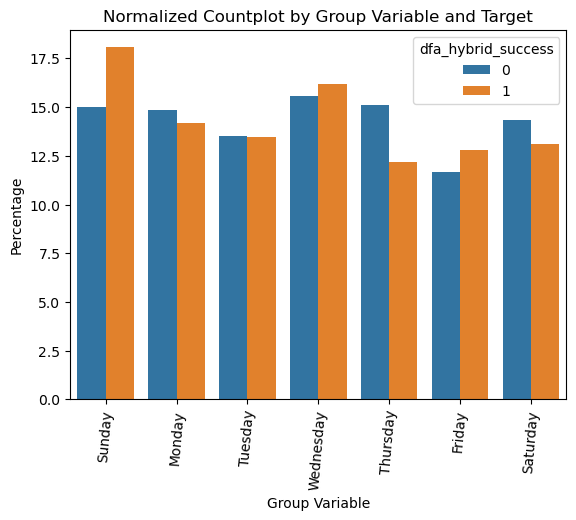

In [17]:
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
x = "day_of_week"
return_grouped_plot(x, "dfa_score_success", order=order)
return_grouped_plot(x, "dfa_ur_success", order=order)
return_grouped_plot(x, "dfa_hybrid_success", order=order)

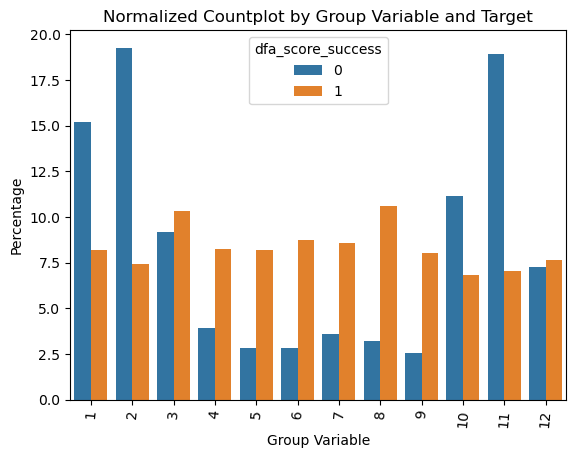

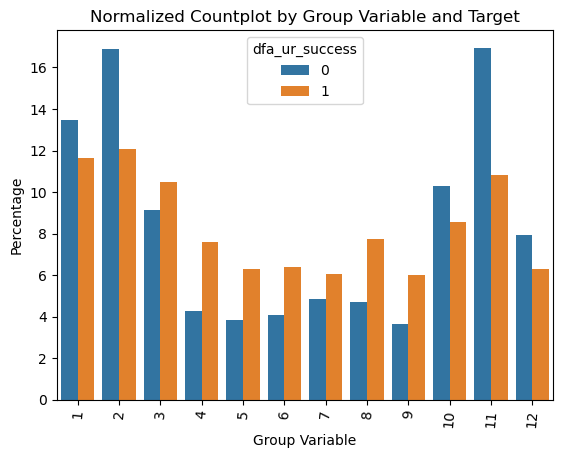

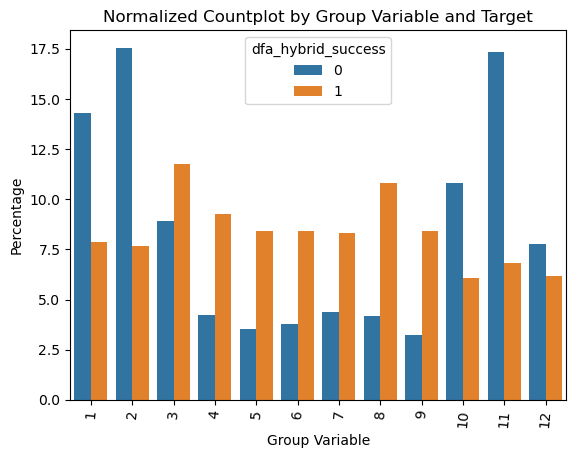

In [18]:
order = None
x = "month"
return_grouped_plot(x, "dfa_score_success", order=order)
return_grouped_plot(x, "dfa_ur_success", order=order)
return_grouped_plot(x, "dfa_hybrid_success", order=order)

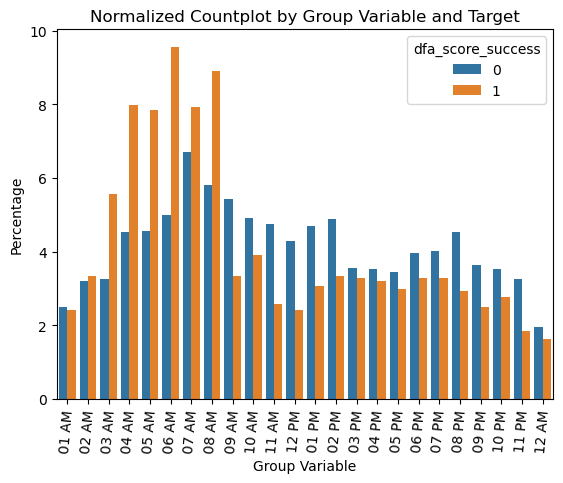

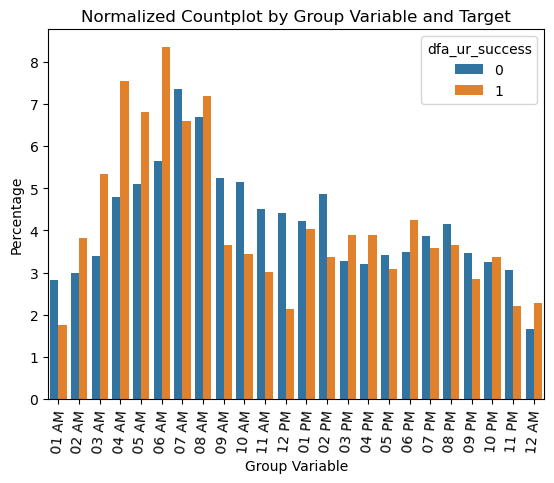

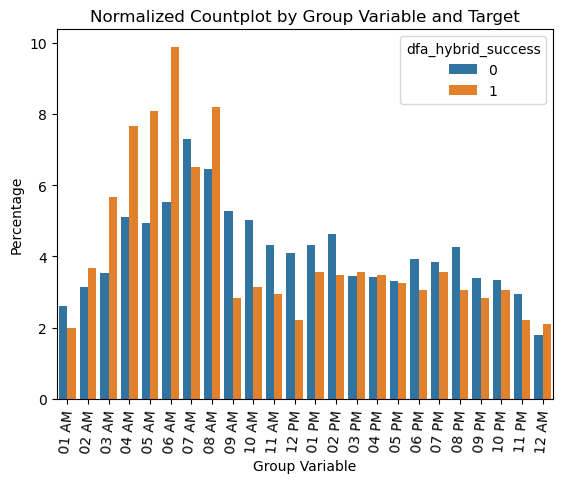

In [20]:
order = twelve_hour_index
x = "12_hour"
return_grouped_plot(x, "dfa_score_success", order=order)
return_grouped_plot(x, "dfa_ur_success", order=order)
return_grouped_plot(x, "dfa_hybrid_success", order=order)

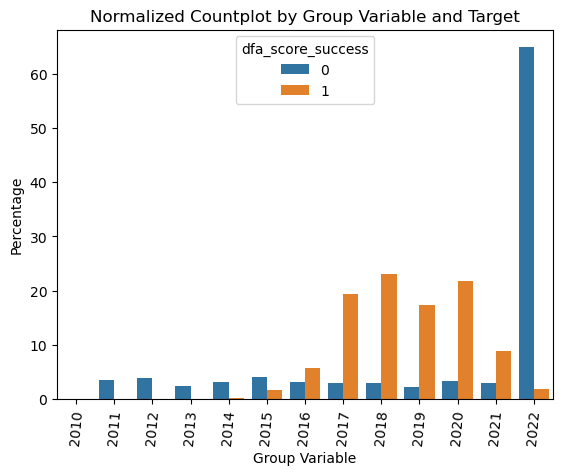

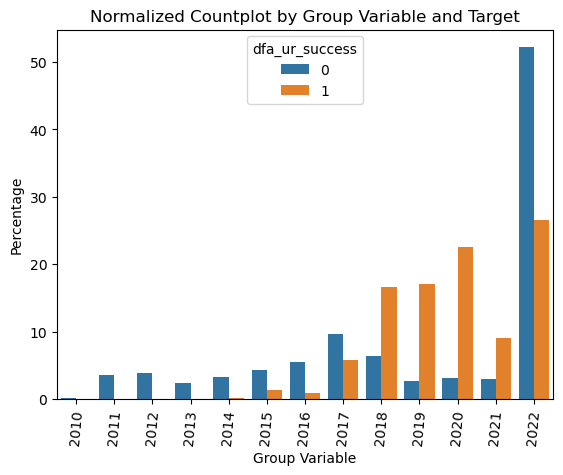

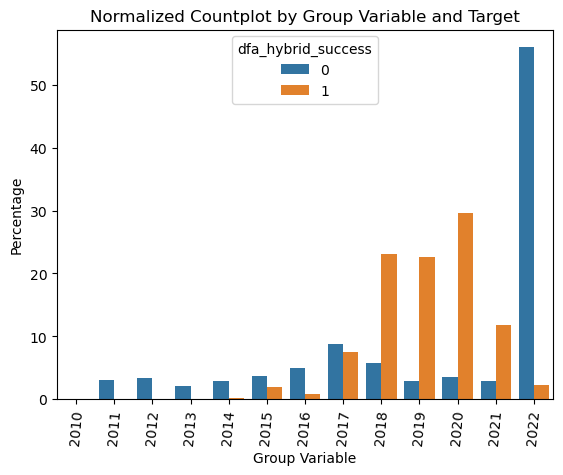

In [21]:
order = None
x = "year"
return_grouped_plot(x, "dfa_score_success", order=order)
return_grouped_plot(x, "dfa_ur_success", order=order)
return_grouped_plot(x, "dfa_hybrid_success", order=order)

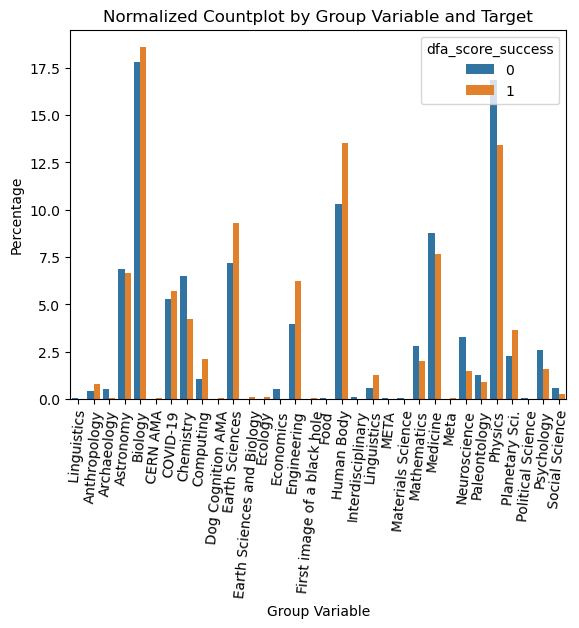

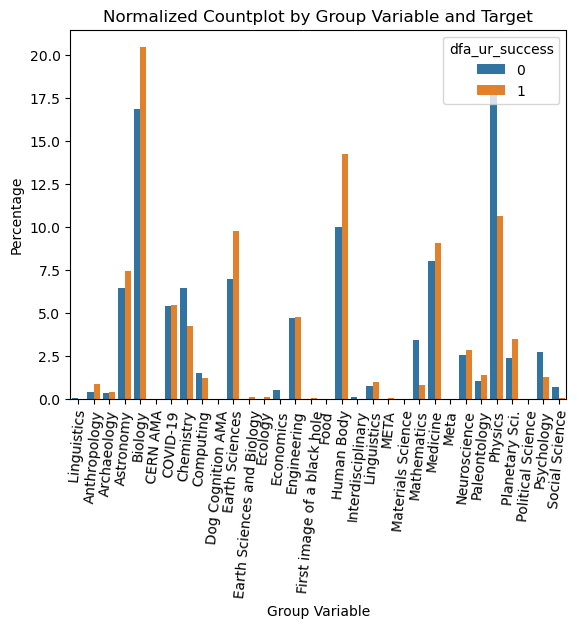

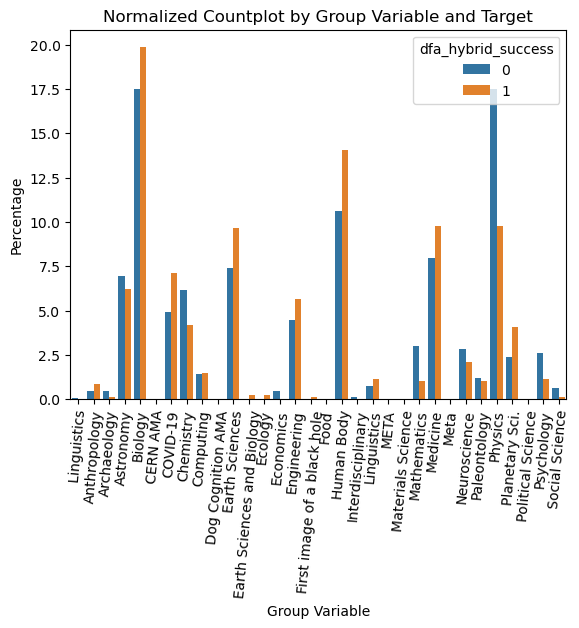

In [22]:
order = None
x = "tag"
return_grouped_plot(x, "dfa_score_success", order=order)
return_grouped_plot(x, "dfa_ur_success", order=order)
return_grouped_plot(x, "dfa_hybrid_success", order=order)


<font size = "3"> <p style="font-family:verdana"> [these are just stream of consciousness (SOC notes)]: physics and psych are both consistently low; math has less upvote ratio than its score, so I would bet it has the fewest unique or active contributors/ human body, earch sciences are more consistent, probably bigger (popular science) </p></font> 

In [23]:
# has actually pretty high score, and then the upvote ratio is pretty lowered, and we have a case where
# we have smaller subreddits with few but dedicated active users may see posts with high score with a relatively lower upvote percentage

# + upvote goes down
current_tag = "Engineering"
print(len(dfa[dfa["tag"] == current_tag]))
print(dfa[dfa["tag"] == current_tag]["author"].nunique())
print(
    dfa[dfa["tag"] == current_tag]["author"].nunique()
    / (len(dfa[dfa["tag"] == current_tag]))
)

190
150
0.7894736842105263


In [26]:
# + upvote goes down
current_tag = "Computing"
print(len(dfa[dfa["tag"] == current_tag]))
print(dfa[dfa["tag"] == current_tag]["author"].nunique())
print(
    dfa[dfa["tag"] == current_tag]["author"].nunique()
    / (len(dfa[dfa["tag"] == current_tag]))
)

58
39
0.6724137931034483


In [25]:
#  flips in the opposite way--postive upvotes goes up relative to score
current_tag = "Neuroscience"
print(len(dfa[dfa["tag"] == current_tag]))
print(dfa[dfa["tag"] == current_tag]["author"].nunique())
print(
    dfa[dfa["tag"] == current_tag]["author"].nunique()
    / (len(dfa[dfa["tag"] == current_tag]))
)

107
96
0.897196261682243


## <div align="left"><span style="font-family: Georgia; color:#3b638c">Looked at a few other things like author activity | was uneventful </div>
- number of author's posts relative to total number of posts for that tag (but takeing out DELETED)

In [45]:
def print_tag_statistics(tag):
    tag_df = dfa[dfa["tag"] == tag]
    num_posts = len(tag_df)
    num_unique_authors = tag_df["author"].nunique()
    author_ratio = num_unique_authors / num_posts

    print(f"Tag: {tag}")
    print(f"Number of Posts: {num_posts}")
    print(f"Number of Unique Authors: {num_unique_authors}")
    print(f"Author Ratio: {author_ratio:.2f}\n")


# Example usage:
current_tag = "Engineering"
print_tag_statistics(current_tag)

current_tag = "Computing"
print_tag_statistics(current_tag)

current_tag = "Neuroscience"
print_tag_statistics(current_tag)

# some quick spalunking
grouped_df = (
    dfa.groupby("author")["normalized_post_count"].sum().reset_index(name="count")
)
top_authors = [
    x
    for x in list(grouped_df[grouped_df["count"] > 0.005]["author"])
    if "DELETED" not in x
]
dfa["top_contributor"] = dfa["author"].apply(lambda x: 1 if x in top_authors else 0)
top_contributor_counts = dfa.top_contributor.value_counts()
print(top_contributor_counts)

Tag: Engineering
Number of Posts: 190
Number of Unique Authors: 150
Author Ratio: 0.79

Tag: Computing
Number of Posts: 58
Number of Unique Authors: 39
Author Ratio: 0.67

Tag: Neuroscience
Number of Posts: 107
Number of Unique Authors: 96
Author Ratio: 0.90



## <div align="left"><span style="font-family: Georgia; color:#3b638c">Create Model DataFrame</div>

In [50]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_df, val_test_df = train_test_split(data_df, train_size=0.8, random_state=42)
val_df, test_df = train_test_split(val_test_df, train_size=0.5, random_state=42)

# Get the sizes of each split
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

# Separate features and target variables
X_train = train_df["text"]
y_train = train_df["binary_target"]

X_val = val_df["text"]
y_val = val_df["binary_target"]

X_test = test_df["text"]
y_test = test_df["binary_target"]

print("  Training size: {:,}".format(train_size))
print("Validation size: {:,}".format(val_size))
print("      Test size: {:,}".format(test_size))

  Training size: 3,364
Validation size: 420
      Test size: 421


# <div align="center"><span style="font-family: Georgia; color:#01386a">Model Buildign for Feature Importance</div>

Will look at BERT predictions--selected this approach first because I Thought I I could get some ensemble models trained quickly and then it would be intersting to look at how much better the combined approach could do and how the errors are different between them.  Unfortunately I ran out of time!

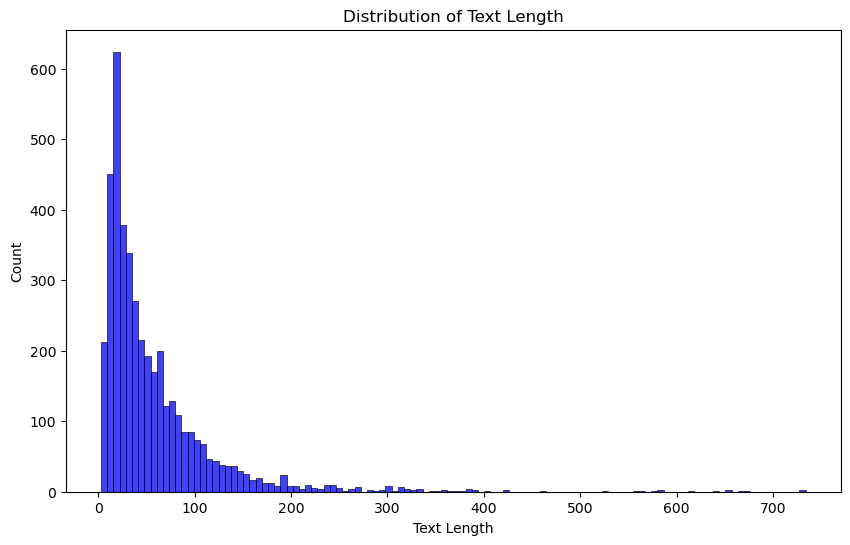

In [100]:
## plot the distribution of `text` lengths
plt.figure(figsize=(10, 6))
sns.histplot(text_len, kde=False, color="blue")

## sets the axis labels and title
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.title("Distribution of Text Length")

## displays the plot
plt.show()

In [92]:
train_pool = Pool(X_train, y_train)

test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(
    iterations=500,
    custom_metric=["Logloss", "Precision", "AUC"],
)

model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=False,
    plot=True,
)
print(model.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Logloss': 0.2677856679199484, 'Precision': 0.9288461538461539}, 'validation': {'Logloss': 0.5074979420087015, 'AUC': 0.7884630534110604, 'Precision': 0.6370967741935484}}


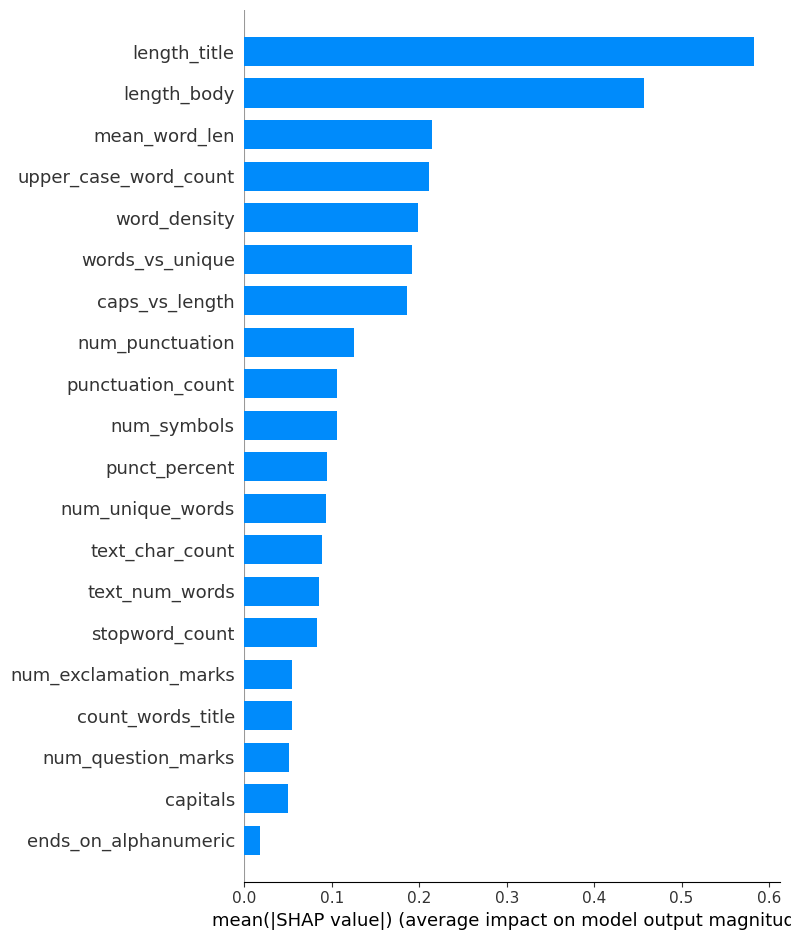

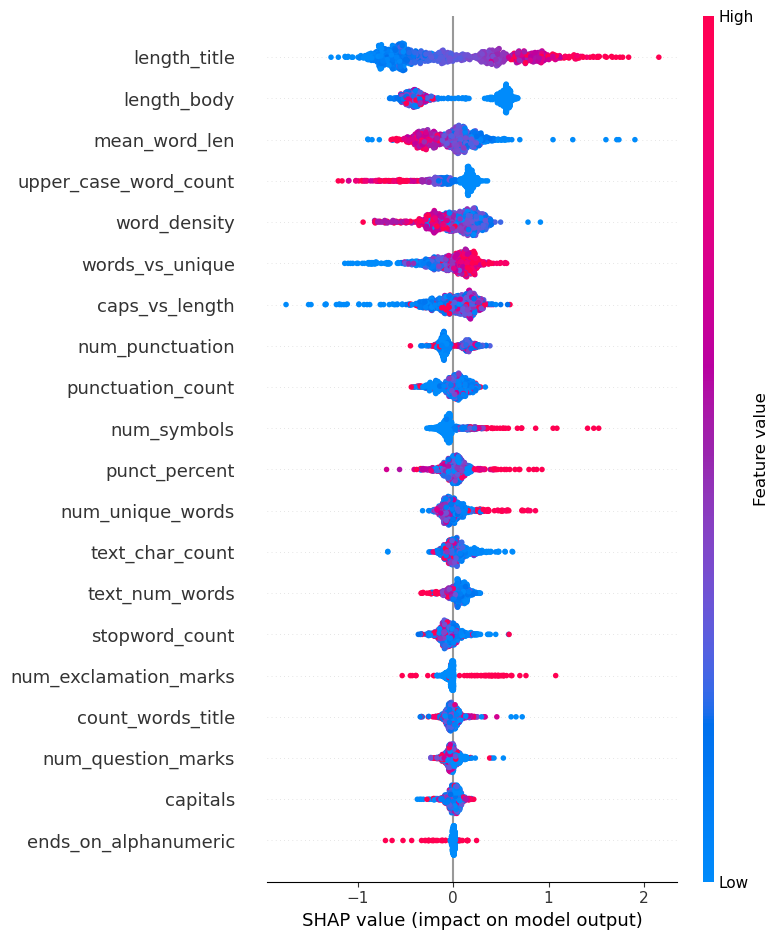

In [96]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_pool)

# feature importance plots
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=x_features)
shap.summary_plot(shap_values, X_test, feature_names=x_features)

## Bert Model

In [ ]:
# Trained this on Collab originally for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loads the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
# train test
train_encodings = tokenizer(
    list(X_train), truncation=True, padding=True, max_length=128
)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [ ]:
train_inputs = torch.tensor(train_encodings["input_ids"]).to(device)
train_masks = torch.tensor(train_encodings["attention_mask"]).to(device)
train_labels = torch.tensor(y_train.values).to(device)

test_inputs = torch.tensor(test_encodings["input_ids"]).to(device)
test_masks = torch.tensor(test_encodings["attention_mask"]).to(device)
test_labels = torch.tensor(y_test.values).to(device)

# Creates PyTorch datasets and data loaders
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=8)

test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=8)

# Loads the BERT model and move it to the GPU if available
model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)

# Defines the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Best accuracy initialization
best_accuracy = 0.0

In [ ]:
# Trains the model
model.train()
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0

    for step, batch in enumerate(train_loader):
        # Move batch tensors to the same device as the model
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Clears the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Retrieves the loss
        loss = outputs.loss

        # Backward pass for gradient calculation
        loss.backward()

        # Updates the weights
        optimizer.step()

        # Accumulates the running loss
        running_loss += loss.item()

        # Predicts labels and calculates the number of correct predictions
        _, predicted = torch.max(outputs.logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy and loss on the entire training set
    accuracy = correct / total
    average_loss = running_loss / len(train_loader)

    # If the current epoch's accuracy is best so far, save this model to disk
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        # torch.save(model.state_dict(), 'best_model.pt')
        torch.save(model, f"{dir}/best_model.pt")

    print(
        f"Epoch {epoch+1}/{10} - Training Loss: {average_loss:.4f} - Training Accuracy: {accuracy:.4f}"
    )

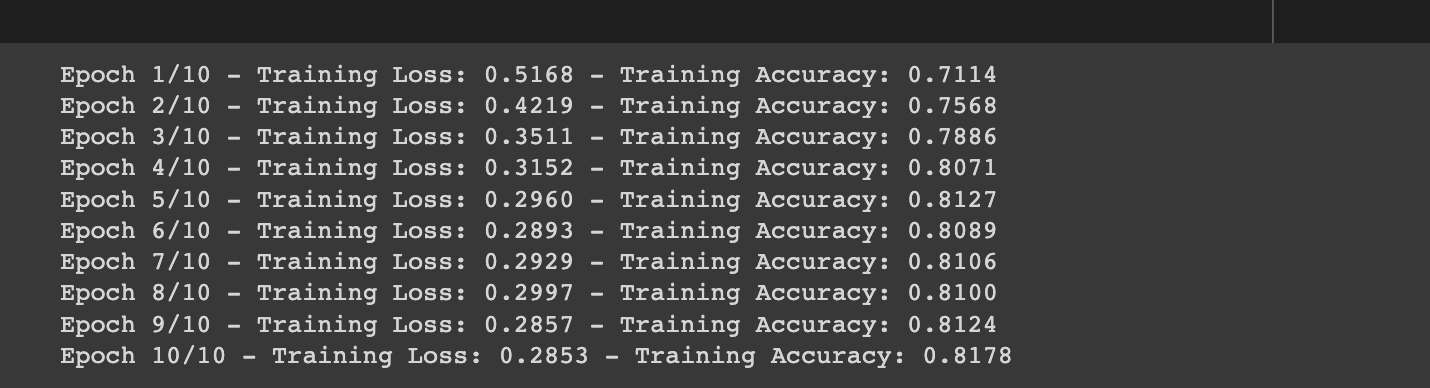

Loss on the eval set was not good--need to go back to this to look more into it

In [ ]:
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Set the model to evaluation mode
model.eval()

# Lists to store actual and predicted values
true_labels = []
pred_labels = []

# Iterate over the test data and generate predictions
for batch in test_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    # Get the predictions and the true labels
    predictions = np.argmax(logits, axis=1)
    true_labels.extend(labels.tolist())
    pred_labels.extend(predictions.tolist())

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

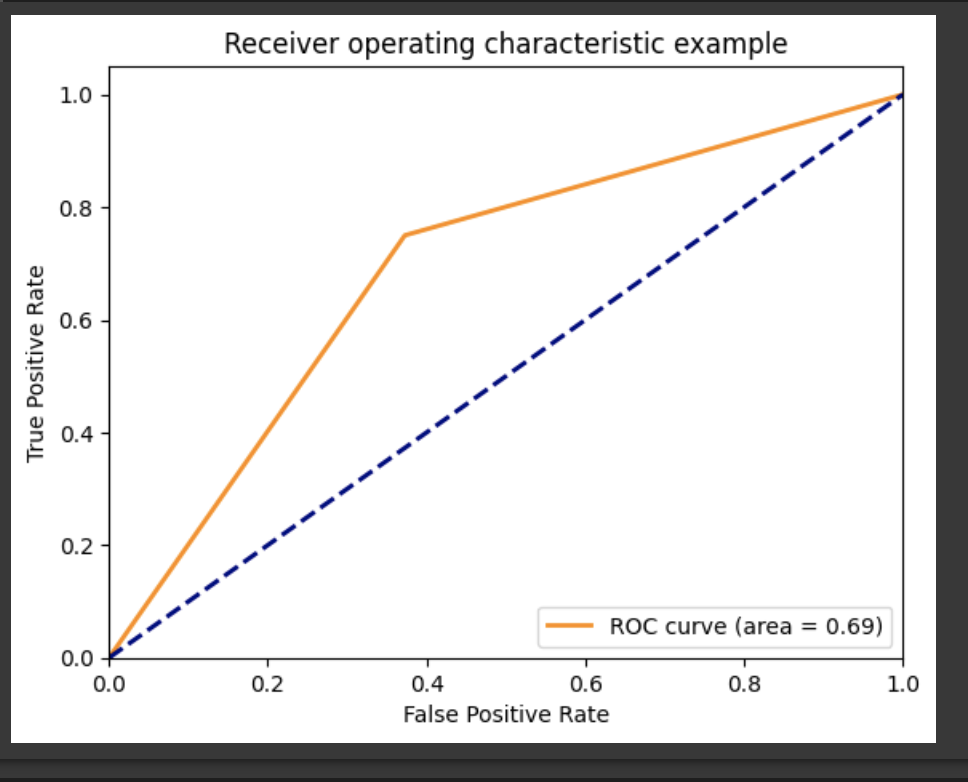

In [ ]:
def predict_post_success(
    test_df: pd.DataFrame,
    model: BertForSequenceClassification,
    tokenizer: BertTokenizer,
):
    # put model in eval mode
    model.eval()

    for i, row in test_df.iterrows():
        #
        post = row["text"]
        true_label = "success" if row["binary_target"] == 1 else "fail"

        # Encode post text
        encoded_text = tokenizer.encode_plus(
            post,
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            truncation=True,  # truncates text
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Move tensors to device
        input_ids = encoded_text["input_ids"].to(device)
        attention_mask = encoded_text["attention_mask"].to(device)

        # Compute model output
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the predicted class
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

        # Map the predicted class to a label name
        predicted_label = "success" if predicted_class == 1 else "fail"

        # Print the true and predicted labels for the post
        print(f"Post {i+1}:")
        print(f"  True label:     {true_label}")
        print(f"  Predicted label: {predicted_label}\n")
        print("=====================================")

In [ ]:
predict_post_success(test_df, model, tokenizer)

# haven't tried this explainer before--looks cool but the model wasn't performing well
# enought to get a sense of whether it was doing what it should
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

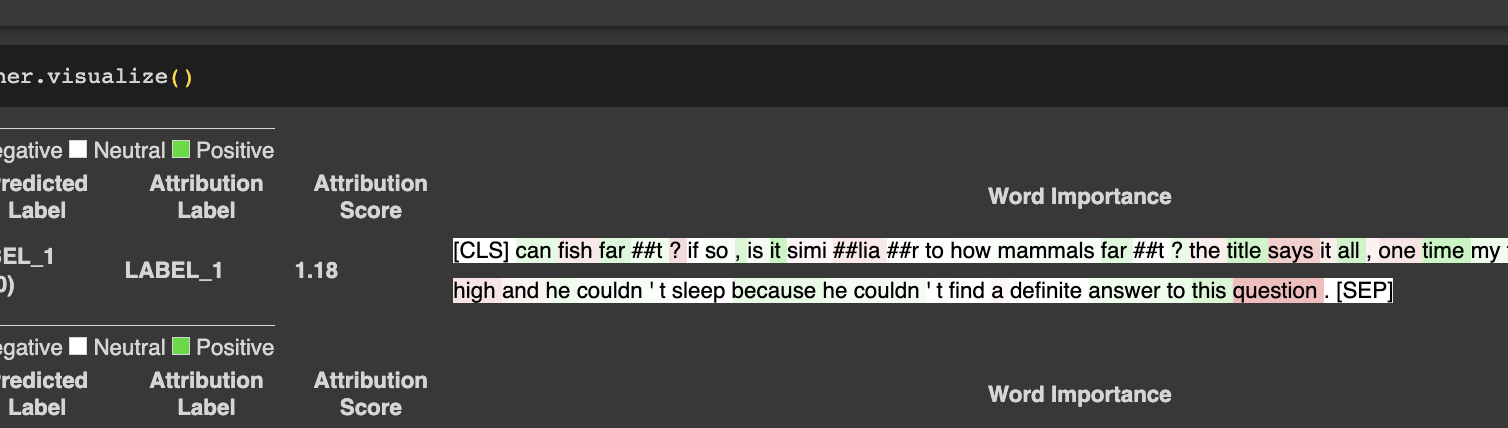

# <div align="center"><span style="font-family: Georgia; color:#01386a">Appendix</div>

<div align="center"><span style="font-family: Georgia; color:#01386a"><h1>EDA</div>

<div align="center"><span style="font-family: Georgia; color:#01386a"><h1>Model Building</div>

<div align="center"><span style="font-family: Georgia; color:#01386a"><h1>Model Tuning</div>

<div align="center"><span style="font-family: Georgia; color:#01386a"><h1>Model Evaluation</div>

<div align="center"><span style="font-family: Georgia; color:#01386a"><h1>Analysis Summary and Final Thoughts</div>

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Understand Data Types</div>

In [ ]:
df.isna().sum()

In [ ]:
df_no_body = df[df["body"].isna()]
dfn = df_no_body.copy()

print("For the dataframe where there is not body of a post: ")
print(f"There {len(dfn)} entrees with:")
print(f" {dfn.title.nunique()} unique titles")
print(f" {dfn.tag.nunique()} unique tags, which include: {dfn.tag.unique()}")

In [ ]:
dfw = df[~df["body"].isna()]

print("For the dataframe where there IS a body post: ")
print(f"There {len(dfw)} entrees with:")
print(f" {dfw.title.nunique()} unique titles")
print(f" {dfw.tag.nunique()} unique tags, which include: {dfn.tag.unique()}")

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Visualizations and Correlations</div>

df.head()

In [43]:
df.head()

,Unnamed: 0,title,body,tag,datetime,author,score,upvote_ratio,url,upvote_quartiles
0,0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...,4
1,1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...,3
2,2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...,3
3,3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...,2
4,4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...,3


In [44]:
df["score"].corr(df["upvote_ratio"])

0.5483241172951062

In [48]:
len(list(df["score"].values))

4205

In [50]:
# Assuming the DataFrame is stored in the variable df
correlation = df["score"].corr(df["upvote_ratio"])

print("Correlation coefficient:", correlation)

Correlation coefficient: 0.5483241172951062


In [51]:
list(df)

['Unnamed: 0',
 'title',
 'body',
 'tag',
 'datetime',
 'author',
 'score',
 'upvote_ratio',
 'url',
 'upvote_quartiles']

To determine the attributes or factors that contribute to a successful "score" in the given DataFrame, you can perform exploratory data analysis and examine the relationships between the feature columns ('title', 'body', 'tag', 'datetime', 'author') and the target column ('score').

Here are a few steps you can take to analyze the attributes of a successful score:

Descriptive Statistics: Compute descriptive statistics for the 'score' column to gain a high-level understanding of its distribution, such as mean, median, and standard deviation. This will provide insights into the overall score values and their variability.

Visualizations: Create visualizations to explore the relationships between each feature column and the target column. For numerical features, scatter plots or line plots can show how the feature values relate to the score. For categorical features, bar plots or box plots can display the distribution of scores across different categories.

Correlation Analysis: Calculate the correlation coefficients between the 'score' column and each of the numerical feature columns using methods like Pearson correlation. This can help identify any linear relationships between the numerical features and the target column.

Feature Importance: Utilize machine learning techniques like feature importance from regression models or decision trees to understand the relative importance of each feature in predicting the 'score'. This can provide insights into which features have the most influence on the target variable.

Text Analysis: If the 'title' and 'body' columns contain textual data, you can apply natural language processing techniques to extract relevant features, such as word frequencies, sentiment analysis, or topic modeling. These analyses can help identify the language or content characteristics associated with successful scores.

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Explore date vs score</div>

## <div align="left"><span style="font-family: Georgia; color:#3b638c">Investigated *Unamed:0* feature; Fairly unintersting so I put the quick and dirty EDA at the end of this notebook</br>

<hr style="height:5px"><span style='background :#d0fefe; color: black; font-size:18px;' > Key Takeaway: Does not seem to be related to an index nor do they hold obvious interest as a potential subgroup </span><hr>

&#10148;<font size = "3"> <span style="font-family:verdana"> Invetigated the `Unammed: 0` beacause I had no context on what it was and considered for a second it was potentially a data `gotcha` (ill be honest). </br>
&#10148;<font size = "3"> <span style="font-family:verdana"> Seems innocuous. </span></font> </br>

In [51]:
# Compute the shift relative to the "index" value in the prior row
# note that this is after I checked that it was sorted, but I would put a code check in if I were planning
# to reuse
df_unammed = dfa.copy()

df_unammed["computed_shift"] = (
    df_unammed["Unnamed: 0"].shift(+1) - df_unammed["Unnamed: 0"]
)
new_start_indexes = list(df_unammed[df_unammed["computed_shift"] > 0].index)
print(len(new_start_indexes))

2


Create new sub-dataframes for--just run through comparing some of the feature to rule out obvious group differences that might be important

In [52]:
dfa1 = df_unammed.loc[0 : new_start_indexes[0] - 1].copy()
dfa1["df_label"] = 1
dfa2 = df_unammed.loc[new_start_indexes[0] : new_start_indexes[1] - 1].copy()
dfa2["df_label"] = 2
dfa3 = df_unammed.loc[new_start_indexes[1] :].copy()
dfa3["df_label"] = 3

**Concatentate with labels to facilitate plotting**

In [54]:
dfp = pd.concat(
    [
        dfa1[
            [
                "datetime",
                "tag",
                "year",
                "month",
                "day_of_week",
                "hour_of_day",
                "12_hour",
                "score",
                "upvote_ratio",
                "df_label",
            ]
        ],
        dfa2[
            [
                "datetime",
                "tag",
                "year",
                "month",
                "day_of_week",
                "hour_of_day",
                "12_hour",
                "score",
                "upvote_ratio",
                "df_label",
            ]
        ],
        dfa3[
            [
                "datetime",
                "tag",
                "year",
                "month",
                "day_of_week",
                "hour_of_day",
                "12_hour",
                "score",
                "upvote_ratio",
                "df_label",
            ]
        ],
    ]
)

Just breaking up the tags etc... so easier to plot subsets without plots getting too huge

In [55]:
dftag1 = dfp[
    dfp["tag"].isin(
        [
            "Biology",
            "Physics",
            "Human Body",
            "Medicine",
            "Earth Sciences",
            "Astronomy",
            "Chemistry",
            "COVID-19",
            "Engineering",
            "Planetary Sci.",
            "Neuroscience",
            "Mathematics",
            "Psychology",
        ]
    )
]

dftag2 = dfp[
    dfp["tag"].isin(
        [
            "Computing",
            "Paleontology",
            "Linguistics",
            "Anthropology",
            "Social Science",
            "Archaeology",
            "Economics",
            "Interdisciplinary",
            "Ecology",
            "Earth Sciences and Biology",
        ]
    )
]

dftag3 = dfp[
    dfp["tag"].isin(
        [
            "  Linguistics",
            "META",
            "Meta",
            "First image of a black hole",
            "Dog Cognition AMA",
            "CERN AMA",
            "Materials Science",
            "Political Science",
            "Food",
        ]
    )
]

### <div align="left"><span style="font-family: Georgia; color:#738595">Look at feature distributions</div>

In [56]:
print(
    "DFA1\n", "Earliest: ", dfa1.datetime.min(), "\n Latest:", dfa1.datetime.max(), "\n"
)
print(
    "DFA2\n", "Earliest: ", dfa2.datetime.min(), "\n Latest:", dfa2.datetime.max(), "\n"
)
print("DFA3\n", "Earliest: ", dfa3.datetime.min(), "\n Latest:", dfa3.datetime.max())

DFA1
 Earliest:  2010-10-29 12:18:12 
 Latest: 2022-12-09 13:06:01 

DFA2
 Earliest:  2014-07-17 07:50:56 
 Latest: 2022-03-14 07:00:21 

DFA3
 Earliest:  2022-01-11 08:14:49 
 Latest: 2022-02-27 08:43:22


<font size = "3"> <p style="font-family:verdana"> It makes sense that the order from largest time period is DFA1 > DFA2 > DFA3 as that is what we see with the overall data sample sizes as well. </p></font>


<Axes: xlabel='df_label', ylabel='score'>

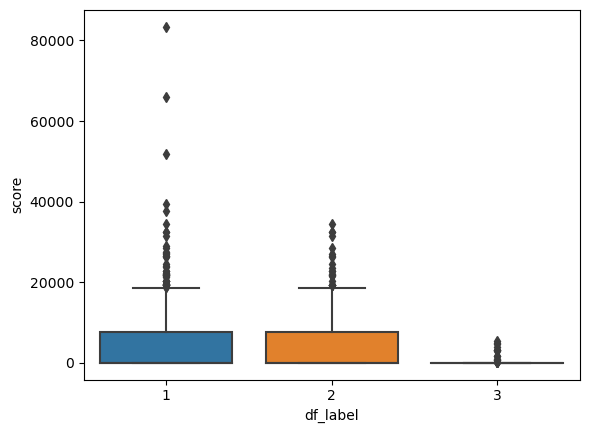

In [57]:
sns.boxplot(data=dfp, y="score", x="df_label")

<Axes: xlabel='df_label', ylabel='upvote_ratio'>

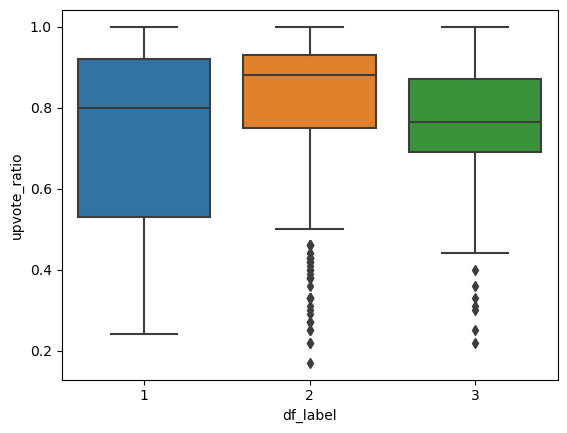

In [58]:
sns.boxplot(data=dfp, y="upvote_ratio", x="df_label")

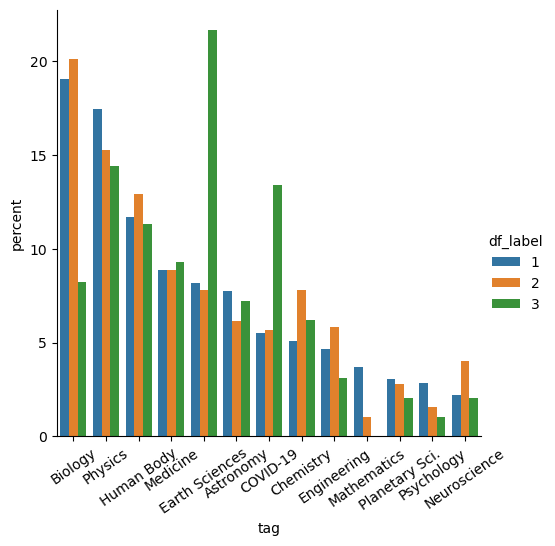

In [59]:
x, y = "tag", "df_label"

(
    dftag1.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe((sns.catplot, "data"), x=x, y="percent", hue=y, kind="bar")
)
plt.xticks(rotation=35)
plt.show()

Interesting to note that the small dataset of only jan/feb of 2022 had lots of relatice Covid-19 and medicine posts

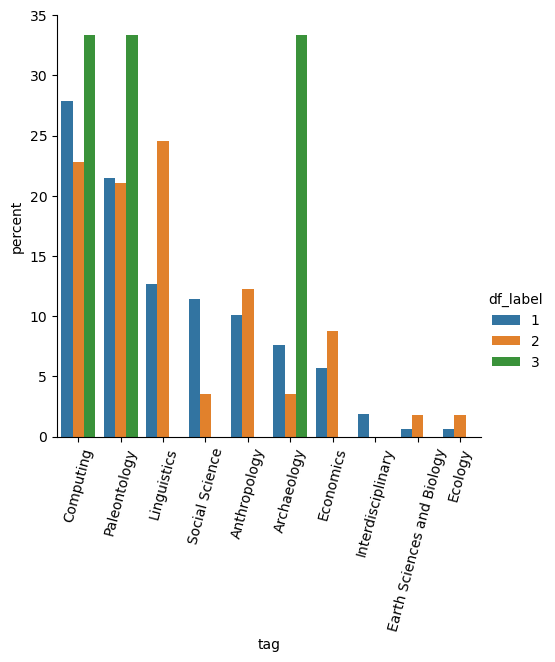

In [61]:
x, y = "tag", "df_label"

(
    dftag2.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe((sns.catplot, "data"), x=x, y="percent", hue=y, kind="bar")
)
plt.xticks(rotation=75)
plt.show()

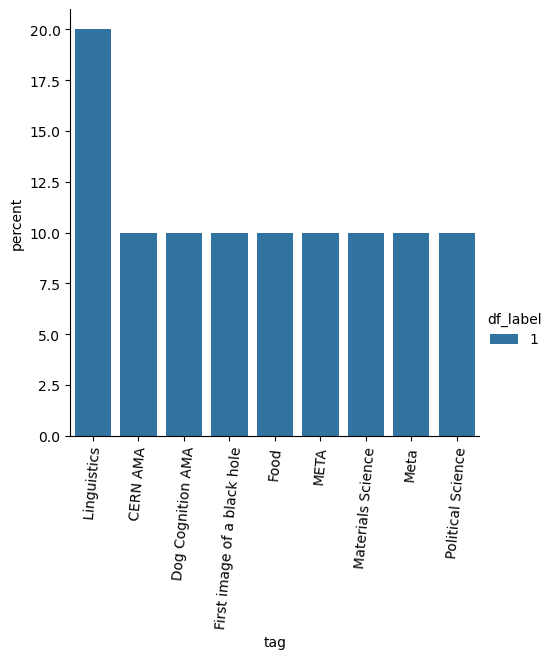

In [43]:
x, y = "tag", "df_label"

(
    dftag3.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe((sns.catplot, "data"), x=x, y="percent", hue=y, kind="bar")
)
plt.xticks(rotation=85)
plt.show()

These ones were so infrequent that we only got a few in the very large set that had the most records

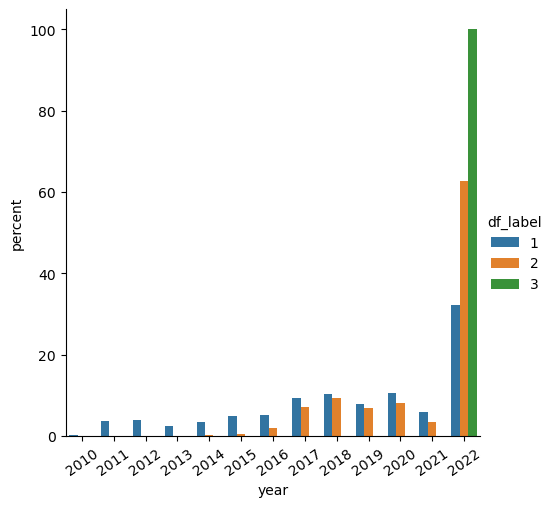

In [44]:
x, y = "year", "df_label"

fig = (
    dfp.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe((sns.catplot, "data"), x=x, y="percent", hue=y, kind="bar")
)
plt.xticks(rotation=35)
plt.show()

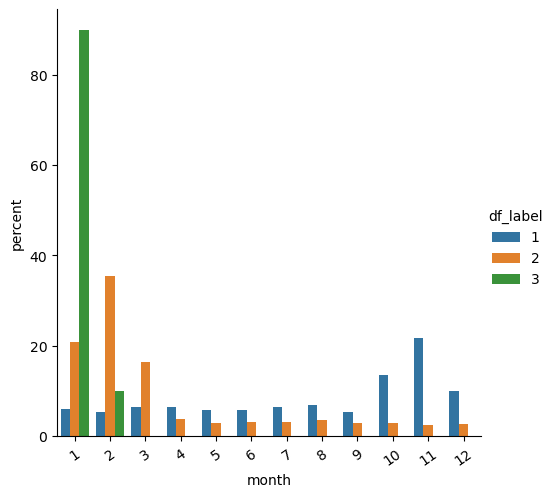

In [45]:
x, y = "month", "df_label"

fig = (
    dfp.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe((sns.catplot, "data"), x=x, y="percent", hue=y, kind="bar")
)
plt.xticks(rotation=35)
plt.show()

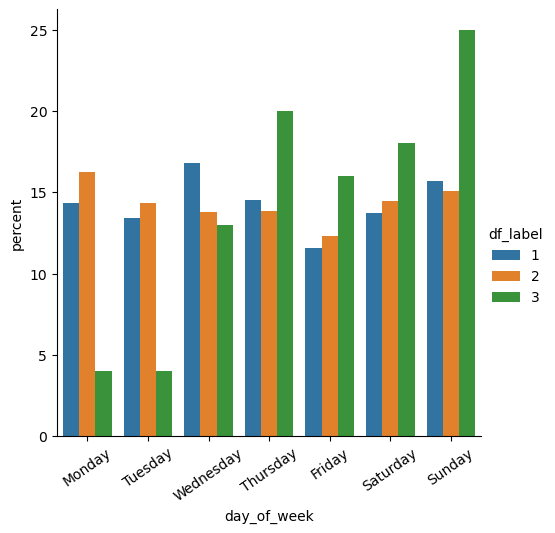

In [46]:
x, y = "day_of_week", "df_label"

fig = (
    dfp.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe(
        (sns.catplot, "data"),
        x=x,
        y="percent",
        hue=y,
        kind="bar",
        order=[
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
            "Sunday",
        ],
    )
)
plt.xticks(rotation=35)
plt.show()

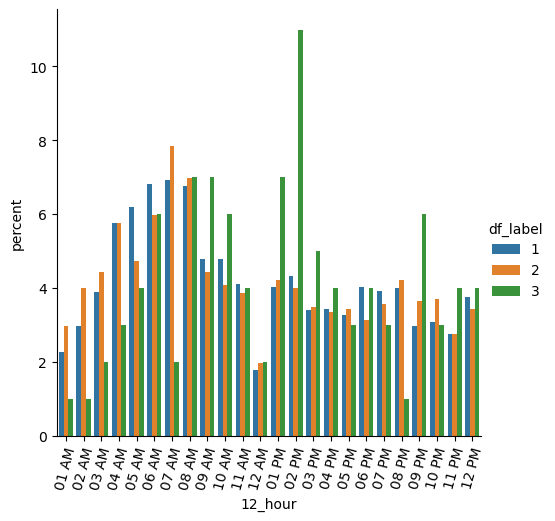

In [49]:
x, y = "12_hour", "df_label"

fig = (
    dfp.groupby(y)[x]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .pipe(
        (sns.catplot, "data"),
        x=x,
        y="percent",
        hue=y,
        kind="bar",
        order=twelve_hour_index,
    )
)
plt.xticks(rotation=75)
plt.show()

No crazy changes there given the green is just due to such a small. Normally I would run stats just for the thoroughness, but the relative pattern stands across all groups, so i'm not too worried about this for now.